# メモ
- importance0除去
- num_data除去
    

# 特徴量
## pitch
- 試合内投球数
- イニング
- イニング内打席数
- 打席内投球数
- 投手投球左右
- 打者打席左右
- 打者打順
- プレイ前アウト数
- プレイ前ボール数
- プレイ前ストライク数
- プレイ前走者状況

### 追加
- ホームチームID
- アウェイチームID
- 球場ID
- 試合種別詳細
- 表裏
- 打者チームID
- 打者守備位置
- 打者試合内打席数
- プレイ前ホームチーム得点数
- プレイ前アウェイチーム得点数
- 投手登板順
- 投手イニング投球数
- 投手試合内対戦打者数

## player
### 打者&投手
- 位置
- 身長
- 体重
- 年俸
- 出身国

### 追加
- ドラフト順位

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df_tr_pitch = pd.read_csv('../data/train_pitch.csv')
df_tr_player = pd.read_csv('../data/train_player.csv')
df_te_pitch = pd.read_csv('../data/test_pitch.csv')
df_te_player = pd.read_csv('../data/test_player.csv')
df_smp = pd.read_csv('../data/sample_submit_ball_type.csv', header=None)

In [2]:
import sys
sys.path.append("..")

import tqdm
import time
import preprocess
import importlib
import re
importlib.reload(preprocess)
cnvrt = preprocess.Converter()
df_tr = cnvrt.convert_df(df_tr_pitch, df_tr_player)

In [3]:
features = []
remove = ["num_data", "cat_pitcher_role", "cat_training_player_batter", "cat_training_player_pitcher", "cat_position_pitcher"]
for x in df_tr.keys():
    if re.match(r"^num_|^ord_|^cat_", x) is not None and x not in remove:
        features.append(x)
features

['num_game_throw',
 'ord_inning',
 'num_inning_bat',
 'num_pitch_in_bat',
 'ord_pitching',
 'num_pitcher_vs',
 'num_pitching_game',
 'num_pitching_inning',
 'ord_bat',
 'num_batter_batting',
 'num_point_home',
 'num_point_away',
 'num_out',
 'num_ball',
 'num_strike',
 'cat_pitcher_lr',
 'cat_bat_lr',
 'cat_runner_state',
 'cat_home_id',
 'cat_away_id',
 'cat_dome_id',
 'cat_game_detail',
 'cat_fb',
 'cat_pitcher_team_id',
 'cat_batter_team_id',
 'cat_batter_def_posi',
 'num_height_batter',
 'num_weight_batter',
 'ord_draft_batter',
 'num_annual_salary_batter',
 'cat_position_batter',
 'cat_country_batter',
 'num_height_pitcher',
 'num_weight_pitcher',
 'ord_draft_pitcher',
 'num_annual_salary_pitcher',
 'cat_country_pitcher']

In [4]:
tr_X = df_tr[features]
tr_Y = df_tr["ball_type"]

In [5]:
from sklearn.model_selection import KFold

cv_num = 5
kf = KFold(n_splits=cv_num, shuffle=True)

kf_index = []
for tr_i, te_i in kf.split(tr_X):
    kf_index.append([tr_i, te_i])

In [6]:
from sklearn.metrics import log_loss # モデル評価用(logloss) 
import lightgbm as lgb #LightGBM

# params
params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 8,
    "metric": "multi_logloss",
    "verbose": 2
}

# train
loss_list = []
models = []
for i, kf in enumerate(kf_index):
    train_x = tr_X.iloc[kf[0]]
    train_y = tr_Y.iloc[kf[0]]
    test_x = tr_X.iloc[kf[1]]
    test_y = tr_Y.iloc[kf[1]]
    
    
    train_data = lgb.Dataset(train_x, label=train_y)
    eval_data = lgb.Dataset(test_x, label=test_y)
    
    print(f"train {i}")
    gbm = lgb.train(
        params,
        train_data, 
        valid_sets=eval_data,
        num_boost_round=500,
        verbose_eval=50
    )
    
    models.append(gbm)

train 0
[50]	valid_0's multi_logloss: 1.26084
[100]	valid_0's multi_logloss: 1.20924
[150]	valid_0's multi_logloss: 1.18963
[200]	valid_0's multi_logloss: 1.17828
[250]	valid_0's multi_logloss: 1.17094
[300]	valid_0's multi_logloss: 1.1657
[350]	valid_0's multi_logloss: 1.16158
[400]	valid_0's multi_logloss: 1.15842
[450]	valid_0's multi_logloss: 1.15629
[500]	valid_0's multi_logloss: 1.15435
train 1
[50]	valid_0's multi_logloss: 1.26271
[100]	valid_0's multi_logloss: 1.21198
[150]	valid_0's multi_logloss: 1.19298
[200]	valid_0's multi_logloss: 1.1818
[250]	valid_0's multi_logloss: 1.17456
[300]	valid_0's multi_logloss: 1.16892
[350]	valid_0's multi_logloss: 1.16426
[400]	valid_0's multi_logloss: 1.16126
[450]	valid_0's multi_logloss: 1.15901
[500]	valid_0's multi_logloss: 1.15722
train 2
[50]	valid_0's multi_logloss: 1.25817
[100]	valid_0's multi_logloss: 1.20681
[150]	valid_0's multi_logloss: 1.18772
[200]	valid_0's multi_logloss: 1.17604
[250]	valid_0's multi_logloss: 1.16899
[300]	

In [16]:
import pickle
with open("./models/v5.pickle", "wb") as f:
    pickle.dump(models, f)

# 予測

In [8]:
df_te = cnvrt.convert_df(df_te_pitch, df_te_player, isTrain=False)
te_X = df_te[features]

In [9]:
result = []
for i, model in enumerate(models):
    start = time.time()
    print(f"start model{i}")
    result.append(model.predict(te_X))
    print(f"end time : {time.time()-start}")

start model0
end time : 90.64883613586426
start model1
end time : 87.19493174552917
start model2
end time : 88.12768006324768
start model3
end time : 90.93382906913757
start model4
end time : 92.28981876373291


In [10]:
from scipy.special import softmax
result = np.array(result)
final_result = np.sum(result, axis=0)
final_result = softmax(final_result, axis=1)

In [15]:
df_submit = pd.concat([df_smp[0], pd.DataFrame(final_result)], axis=1).reset_index(drop=True)
df_submit.columns = range(df_submit.shape[1])
df_submit.to_csv("submits/v5.csv", index=False, header=False)

# importance

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
imp = pd.DataFrame(
    {"feature": train_x.keys(),
     "importance": models[0].feature_importance()})
imp

,feature,importance
0,num_game_throw,8631
1,ord_inning,1401
2,num_inning_bat,1665
3,num_pitch_in_bat,4196
4,ord_pitching,1199
5,num_pitcher_vs,2301
6,num_pitching_game,7239
7,num_pitching_inning,5526
8,ord_bat,2443
9,num_batter_batting,775


findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


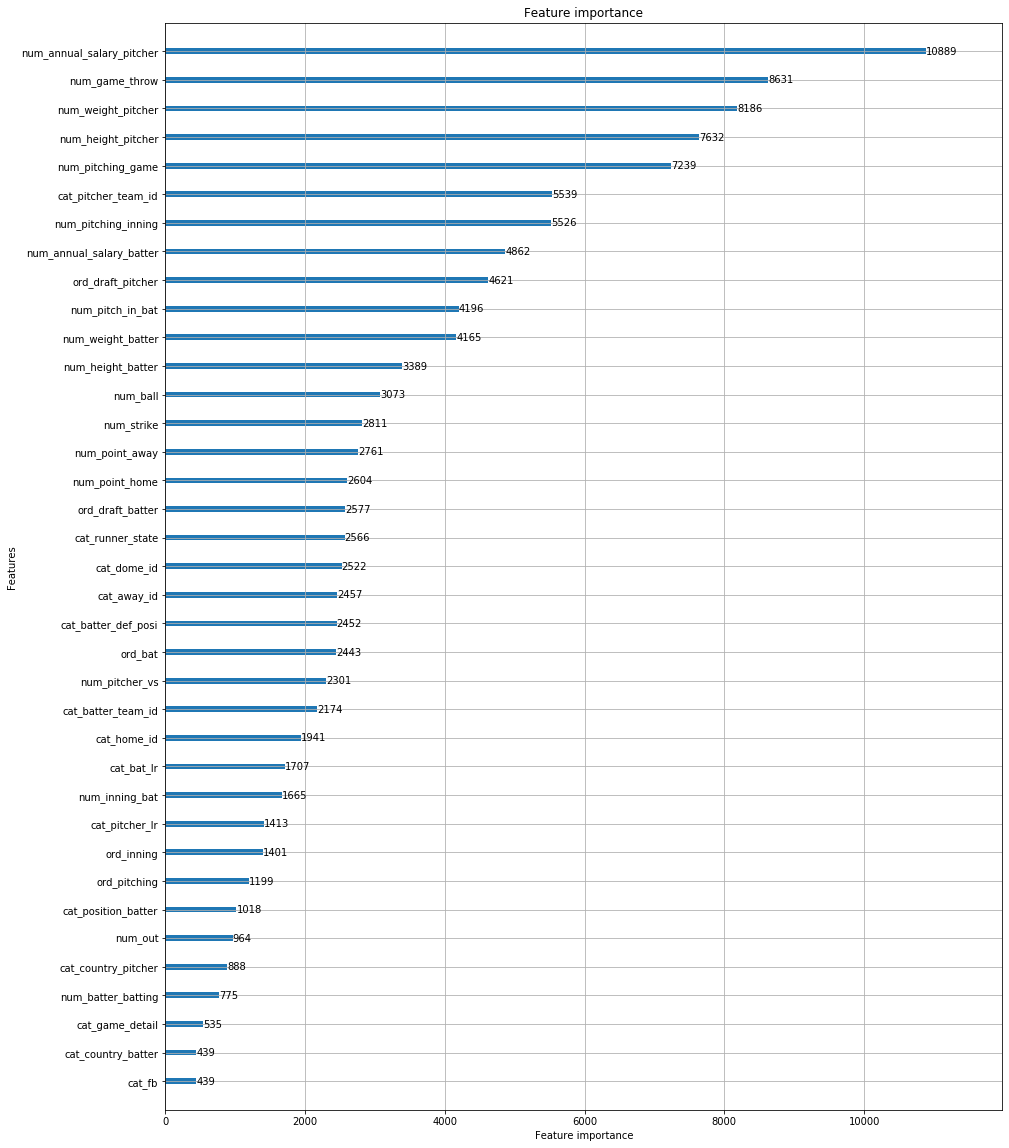

In [14]:
lgb.plot_importance(models[0], figsize=(15,20), ignore_zero=False)